# Angular Power Spectrum

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
from glob import glob

In [5]:
import matplotlib.pyplot as plt
from time import time
import numpy as np
from modules import (bias_model, dNdz_model, 
                     init_sample, Spectrum)
import os
import sys
sys.path.append('/home/mehdi/github/LSSutils')
from lssutils.dataviz import setup_color
import fitsio as ft
import healpy as hp
import lssutils.utils as ut

setup_color()

def run_anafast(map1, mask):
    map1_ = hp.ma(map1)
    map1_.mask = np.logical_not(mask)
    return hp.anafast(map1_.filled(), pol=False)

## Model Power Spectrum


### Mock

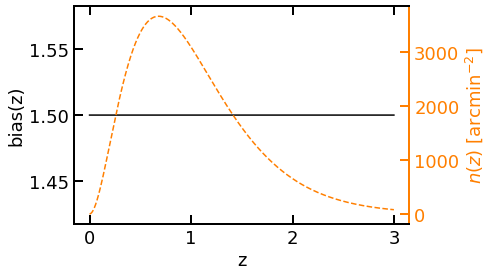

In [5]:
z, b, dNdz = init_sample(kind='mock', plot=True)

In [6]:
Om_b = 0.048206
Om_cdm = 0.307115 - Om_b
model = Spectrum(h=0.6777, Omega0_b=Om_b, Omega0_cdm=Om_cdm, n_s=0.9611, sigma8=0.8225)

h         : 0.6777
T0_cmb    : 2.7255
Omega0_b  : 0.048206
Omega0_cdm: 0.25890900000000006
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9611
nonlinear : False


(7.841288000109608e-08, 2e-05)

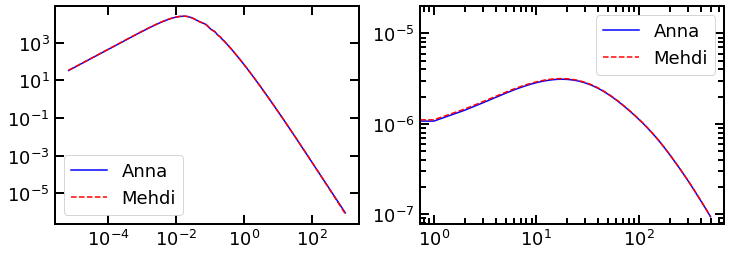

In [9]:
ell = np.arange(500)
model.add_tracer(z, b, dNdz, p=1.6)
model.make_kernels(ell)
cell_mr = model(ell)



# Pk
pk_anna = np.loadtxt('Pk_z0_linear.txt')
cl_anna = np.loadtxt('C_ells_bin1_1_linear.txt')
pk_mr = model.Plin(pk_anna[:, 0])


# test MR with AP
fg, ax = plt.subplots(ncols=2, figsize=(12, 4))

ax[0].loglog(pk_anna[:, 0], pk_anna[:, 1], 'b-',
           pk_anna[:, 0], pk_mr, 'r--')
ax[0].legend(['Anna', 'Mehdi'])  




ax[1].loglog(cl_anna[:, 0], cl_anna[:, 1], 'b-',
           ell, cell_mr, 'r--')
ax[1].legend(['Anna', 'Mehdi'])  
ax[1].set_ylim(ymax=2.0e-5)

## Bias and Redshift Evolution

### QSO

Text(0.5, 0, 'z')

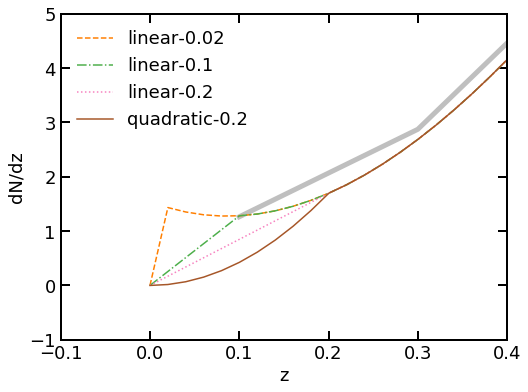

In [9]:
z1, dNdz1 = dNdz_model(z_low=0.02)
z2, dNdz2 = dNdz_model(z_low=0.2)
z3, dNdz3 = dNdz_model(z_low=0.2, kind=2)
z4, dNdz4 = dNdz_model(z_low=0.1)

nz_, z_ = np.loadtxt('/home/mehdi/data/dr9v0.57.0/p38fnl/RF_g.txt').T

assert np.array_equal(z1, z2)
b = bias_model(z1)


plt.figure(figsize=(8, 6))
plt.plot(z_, nz_, lw=5, alpha=0.5, color='grey')

plt.plot(z1, dNdz1, label='linear-0.02')
plt.plot(z4, dNdz4, label='linear-0.1')
plt.plot(z2, dNdz2, label='linear-0.2')
plt.plot(z3, dNdz3, label='quadratic-0.2')

plt.xlim(-0.1, 0.4)
plt.ylim(-1., 5.)
plt.legend(frameon=False)
plt.ylabel('dN/dz')
plt.xlabel('z')

Text(0, 0.5, 'C$_{X}$/C$_{\\rm linear-0.2}$')

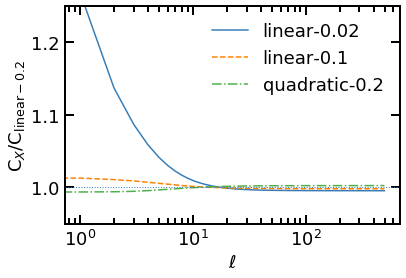

In [14]:
model = Spectrum()

ell = np.arange(500)
t0 = time()
model.add_tracer(z1, b, dNdz1)
model.make_kernels(ell)
cell1 = model(ell)
t1 = time()
print('time', t1-t0)

model.add_tracer(z2, b, dNdz2)
model.make_kernels(ell)
cell2 = model(ell)

model.add_tracer(z3, b, dNdz3)
model.make_kernels(ell)
cell3 = model(ell)

model.add_tracer(z4, b, dNdz4)
model.make_kernels(ell)
cell4 = model(ell)

plt.plot(ell, cell1/cell2, label='linear-0.02')
# plt.loglog(ell, cell2, label='linear-0.2')
plt.plot(ell, cell4/cell2, label='linear-0.1')
plt.plot(ell, cell3/cell2, label='quadratic-0.2')
plt.legend(frameon=False)
plt.axhline(1.0, ls=':', lw=1)
plt.semilogx()
plt.ylim(0.95, 1.25)
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{X}$/C$_{\rm linear-0.2}$')

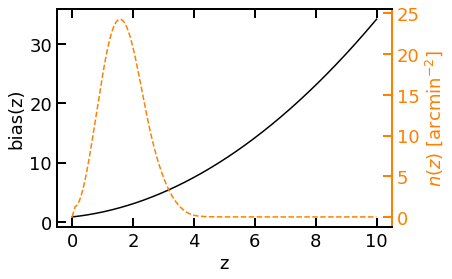

In [10]:
z, b, dNdz = init_sample(kind='qso', plot=True)

In [11]:
model = Spectrum()

ell = np.arange(500)
model.add_tracer(z, b, dNdz, p=1.6)
model.make_kernels(ell)

cells = {}
for fnl in [-100, -10.0, 0.0, 10.0, 100]:
    cells[fnl] = model(ell, fnl=fnl)

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False


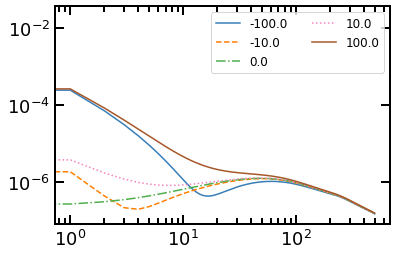

In [14]:
for fnl, cell in cells.items():
    plt.loglog(cell, label=f'{fnl:.1f}')
plt.legend(fontsize=12, ncol=2)

## Generate Mocks

In [5]:
z, b, dNdz = init_sample(kind='qso')

model = Spectrum()

ell = np.arange(3000)
model.add_tracer(z, b, dNdz, p=1.6)
model.make_kernels(ell)

cl_true = model(ell, fnl=0.0)

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False


In [34]:
region = 'NBMZLS'
dcat_ = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/sv3target_QSO_{region}.fits')
rcat_ = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/{region}_randoms-1-0x5.fits')
wsys_ = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/sv3target_QSO_{region}.fits_EdWsys/wsys_v0.fits')['wsys']

bits = [1, 5, 6, 7, 8, 9, 11, 12, 13] # https://www.legacysurvey.org/dr9/bitmasks/
dcat, ix = ut.cutphotmask(dcat_, bits, return_indices=True)
rcat = ut.cutphotmask(rcat_, bits)
wsys = wsys_[ix]

1629292 before imaging veto
1512178 0.928119698617559 after imaging veto
64410796 before imaging veto
58377274 0.9063274734254176 after imaging veto


In [35]:
nside = 256
dhp = ut.hpixsum(nside, dcat['RA'], dcat['DEC'], weights=wsys)
dhp_ = ut.hpixsum(nside, dcat['RA'], dcat['DEC'])*1.0
rhp = ut.hpixsum(nside, rcat['RA'], rcat['DEC'])*1.0


mask = rhp > np.percentile(rhp[rhp>0.0], 3.0) # throw out 3rd quantile

delta = ut.make_overdensity(dhp, rhp, mask)
delta_ = ut.make_overdensity(dhp_, rhp, mask)

In [36]:
fsky = mask.mean()
nbar_sqdeg = np.mean(dhp[mask]) / ut.nside2pixarea(nside, degrees=True)
nbar_sr = (180./np.pi)**(2.0) * nbar_sqdeg
print(nbar_sqdeg, nbar_sr, fsky)

283.9696471341389 932217.3608225454 0.1206041971842448


In [37]:
mask

array([False, False, False, ..., False, False, False])

In [38]:
hp.write_map('/home/mehdi/data/dr9v0.57.0/p38fnl/data/mask_bmzls.hp.fits', mask, fits_IDL=False, dtype=np.float64)

In [17]:
cl_obs = {}
cl_obs['after'] = run_anafast(delta, mask)
cl_obs['before'] = run_anafast(delta_, mask)

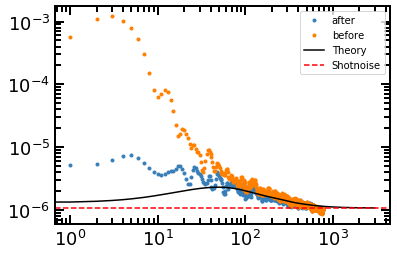

In [22]:
for name, cl_i in cl_obs.items():
    plt.plot(cl_i/fsky, marker='.', ls='None', label=name)
plt.plot(cl_true+1./nbar_sr, 'k-', label='Theory')
plt.axhline(1./nbar_sr, ls='--', color='r', label='Shotnoise')
plt.loglog()
plt.legend(fontsize=10)
# plt.xlim(xmin=50.)
# plt.ylim(0.0, 5.0e-6)

In [31]:
np.savez('/home/mehdi/data/dr9v0.57.0/p38fnl/cl_qso_bzmls.npz', 
        **{**cl_obs, 'nbar_sr':nbar_sr, 'cl_true':cl_true, 'fsky':fsky})

### Creation of Mocks

In [41]:
cls = np.load('/home/mehdi/data/dr9v0.57.0/p38fnl/cl_qso_bzmls.npz', allow_pickle=True)
cls.files

['after', 'before', 'nbar_sr', 'cl_true', 'fsky']

In [42]:
nside = 256
cl_true = cls['cl_true']
nbar_sr = cls['nbar_sr']
fsky = cls['fsky']

In [43]:
delta_g = hp.synfast(cl_true, nside=nside, pol=False, verbose=False)

# approach B
noise_g = hp.synfast(np.ones_like(cl_true)/nbar_sr, nside=nside, pol=False, verbose=False)

# approach A
# n_g_ = nbar_sr*(1+delta_g) # per pixel
# n_g = Poisson(n_g_) 

# Following B ->
# n_g = Round(nbar_sr*(1+delta_g+noise_g))

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


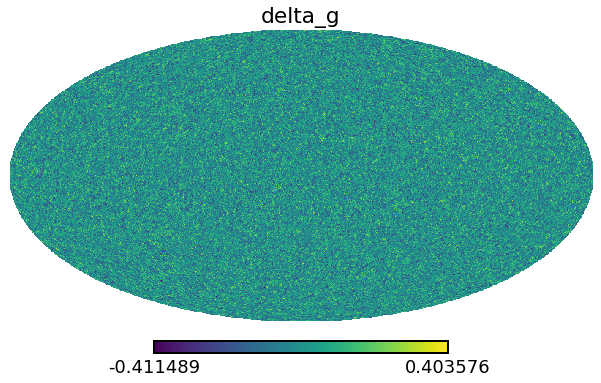

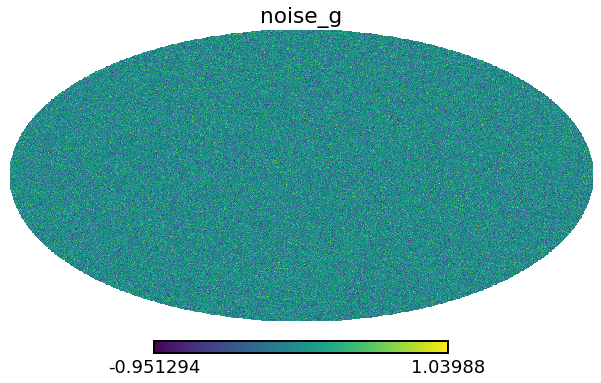

In [10]:
hp.mollview(delta_g, title='delta_g')
hp.mollview(noise_g, title='noise_g')

In [44]:
cl_noise = run_anafast(noise_g, np.ones_like(delta_mock, '?'))

In [45]:
delta_mock = delta_g + noise_g

In [46]:
cl_mock = run_anafast(delta_mock, np.ones_like(delta_mock, '?'))

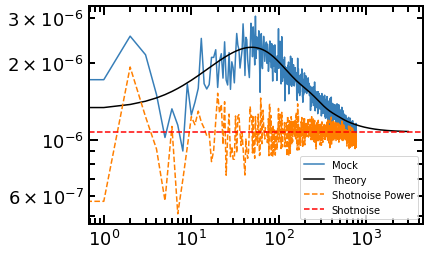

In [47]:
plt.plot(cl_mock, label='Mock')
plt.plot(cl_true+1./nbar_sr, 'k-', label='Theory')
plt.plot(cl_noise, label='Shotnoise Power')
plt.axhline(1./nbar_sr, ls='--', color='r', label='Shotnoise')

plt.loglog()
plt.legend(fontsize=10)

In [27]:
mock_dir = '/home/mehdi/data/dr9v0.57.0/p38fnl/data/mocks/'

nmocks = 100
np.random.seed(85)
seeds = np.random.randint(0, 2**32-1, size=nmocks)
seeds = np.unique(seeds)
print(len(seeds))

for i in range(1,nmocks+1):
    mock_i = os.path.join(mock_dir, f'{i:03d}.hp.fits')
    #print(seeds[i-1], mock_i)

    np.random.seed(seeds[i-1])
    
    delta_g = hp.synfast(cl_true, nside=nside, pol=False, verbose=False)
    noise_g = hp.synfast(np.ones_like(cl_true)/nbar_sr, nside=nside, pol=False, verbose=False)
    
    delta_mock = delta_g + noise_g
    hp.write_map(mock_i, delta_mock, fits_IDL=False, dtype=np.float64, overwrite=True)
    print('.', end='')

100
....................................................................................................

In [21]:
import pandas as pd

In [18]:
### compute cross correlation of the data
from lssutils.lab import get_cl, maps_dr9sv3
from lssutils.lab import histogram_cell

In [16]:
region = 'NBMZLS'
dcat_ = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/sv3target_QSO_{region}.fits')
rcat_ = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/{region}_randoms-1-0x5.fits')
wsys_ = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/sv3target_QSO_{region}.fits_EdWsys/wsys_v0.fits')['wsys']

bits = [1, 5, 6, 7, 8, 9, 11, 12, 13] # https://www.legacysurvey.org/dr9/bitmasks/
dcat, ix = ut.cutphotmask(dcat_, bits, return_indices=True)
rcat = ut.cutphotmask(rcat_, bits)
wsys = wsys_[ix]

1629292 before imaging veto
1512178 0.928119698617559 after imaging veto
64410796 before imaging veto
58377274 0.9063274734254176 after imaging veto


In [17]:
nside = 256
dhp = ut.hpixsum(nside, dcat['RA'], dcat['DEC'], weights=wsys)
dhp_ = ut.hpixsum(nside, dcat['RA'], dcat['DEC'])*1.0
rhp = ut.hpixsum(nside, rcat['RA'], rcat['DEC'])*1.0

In [23]:
mask_ = '/home/mehdi/data/dr9v0.57.0/p38fnl/data/mask_bmzls.hp.fits'
templ_ = '/home/mehdi/data/templates/dr9/pixweight_dark_dr9m_nside256.h5'

In [24]:
#--- read templates
templ = pd.read_hdf(templ_)
templ_np = templ[maps_dr9sv3].values

# --- read mask
mask = hp.read_map(mask_) > 0.5
mask_sysm = (~np.isfinite(templ_np)).sum(axis=1) < 1
mask &= mask_sysm

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [25]:
cl_wsys = get_cl(dhp, rhp, mask, systematics=templ_np, njack=0)
cl_now = get_cl(dhp_, rhp, mask, systematics=templ_np, njack=0)

In [6]:
cl_mock = np.load('/home/mehdi/data/dr9v0.57.0/p38fnl/data/mocks/cl/cl_001.npz', allow_pickle=True)

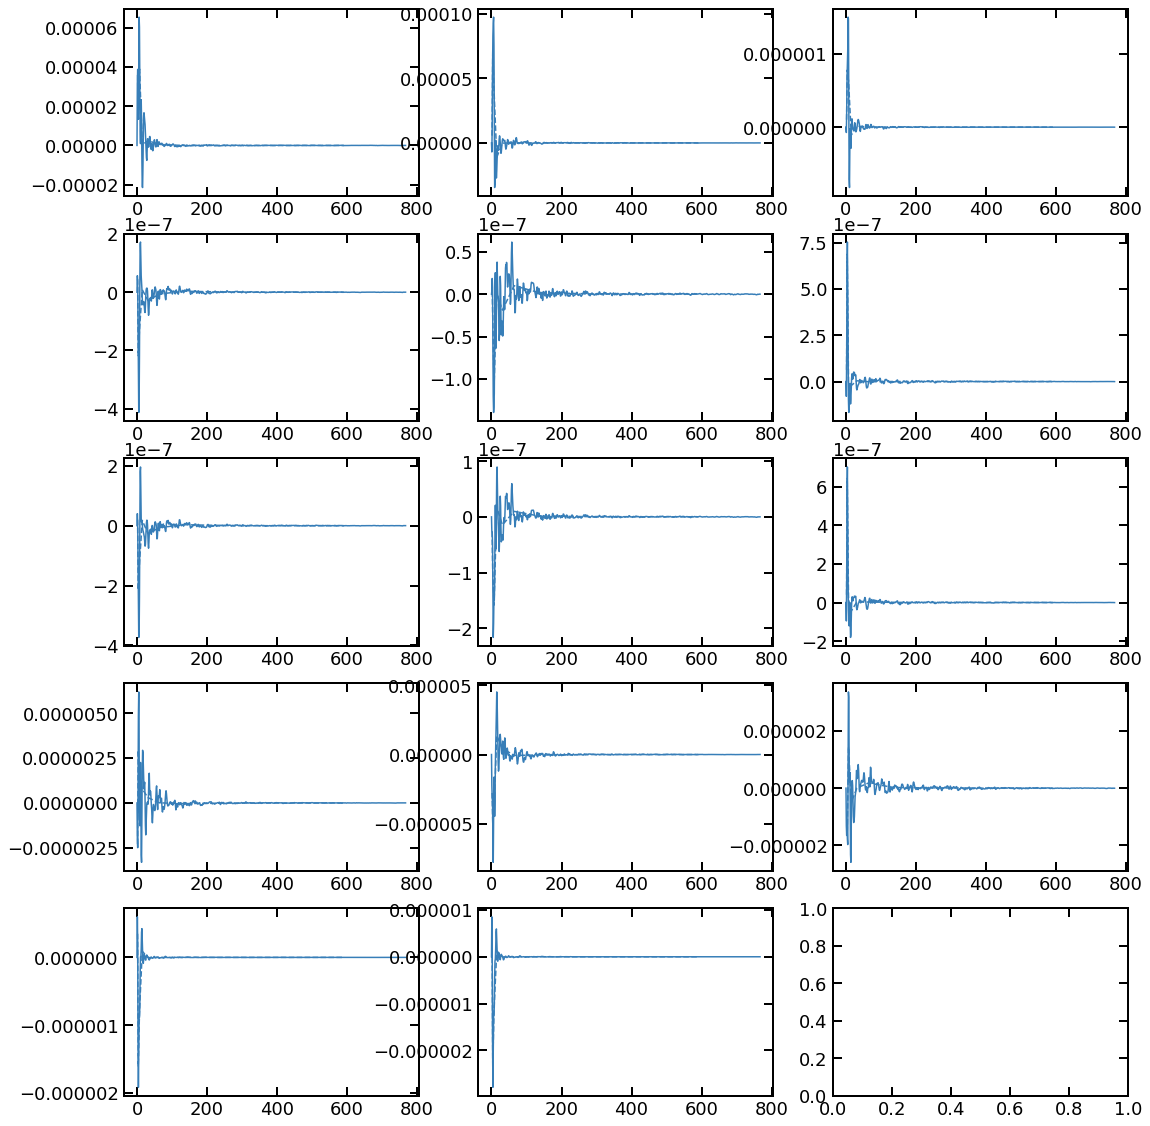

In [14]:
fg, ax = plt.subplots(ncols=3, nrows=5, figsize=(18, 20))

ax = ax.flatten()

for i in range(len(cl_mock['cl_sg'])):
    
    cl_ = cl_mock['cl_sg'][i]['cl']
    lb, clb = histogram_cell(cl_)
    line, = ax[i].plot(cl_)
    ax[i].plot(lb, clb, color=line.get_color())
    

In [ ]:
# calculate 2D angular auto and cross power spectra
# calculate 1D mean density